# Spanning Tree Optimization
#### Author: Tina Tavakolifar
#### Date: 2025-10-21
#### Goal: Compare minimum spanning tree (MST), minimum bottleneck spanning tree (MBST), minimum median spanning tree (MMST), minimum variance spanning tree (MVST) on a weighted undirected graph.

## Abstract
#### This notebook demonstrates the computation of various optimal spanning trees: MST, MBST, MMST, and MVST.
#### The methods utilize Kruskal's algorithm, pathfinding and optimization techniques. Visualizations are included for clarity.  

## Introduction
#### A spanning tree is a subset of graph edges connecting all vertices without cycles.
#### - **MST** : Minimizes total weight.
#### - **MBST** : Minimizes the largest edge weight (bottleneck).
#### - **MMST** : Minimizes the median edge weight.
#### - **MVST** : Minimizes variance of edge weights.

#### This notebook demonstrates Python implementation with 'networkx' and 'matplotlib'.

In [1]:
# Import libraries
from collections import defaultdict
import os
import numpy as np              # For graph handling
import networkx as nx           # Visualizes graphs and runs algorithms such as MST
import matplotlib.pyplot as plt # Plots the graphs

## Graph Definition
#### The graph is loaded from an adjacency matrix stored in 'adj_matrix.csv' and checked for symmetry. This class loads the adjacency matrix from CSV. Builds a sorted edge list (for Kruskal’s algorithm). Provides visualization and layout utilities for consistent positioning. Prints information about the graph structure

In [2]:
# Represents a weighted undigraph.
class Graph:
    script_dir = os.getcwd()
    file = os.path.join(script_dir, 'adj_matrix.csv')
    df = np.loadtxt(file, delimiter=',', dtype=int)

    def __init__(self):
        self.nodes = len(self.df) # number of nodes
        self.node_list = list(range(self.nodes))
        self.symmetry = np.array_equal(self.df, self.df.T)
        
        if self.symmetry:
            # Get upper triangle indices excluding diagonal
            row_index, col_index = np.triu_indices(self.nodes, k=1) 
            edge_dict = {}
            
            for i, j in zip(row_index, col_index):
                if self.df[i, j] > 0:
                    edge_dict[int(i), int(j)] = int(self.df[i, j])
                    
            # Sorts edges by weight in non-descending order (the non-descending sorting table in a list)
            self.sorted_edges = [(u, v, w) for (u, v), w in sorted(edge_dict.items(),
                                                                   key=lambda x: x[1])]

        else: 
            raise ValueError('Error. Please check CSV file.')

    # Creates a fixed layout based on the MST edges.
    # mst_edges is passed because It's calculated outside the class
    def get_layout(self, mst_edges):

        # Just for layout calculation
        g_layout = nx.Graph()
        g_layout.add_nodes_from(self.node_list)
        g_layout.add_weighted_edges_from(mst_edges)

        master_pos = nx.spring_layout(g_layout, seed=42)

        return master_pos
        
    
    # Draws the main graph given a list of weighted edges, node opsition and title.   
    def visualize(self, tree_edges, pos, title):      
        g = nx.Graph()
        g.add_nodes_from(self.node_list)
        g.add_weighted_edges_from(tree_edges)

        edge_labels = nx.get_edge_attributes(g, 'weight')

        # Draws the  graph
        plt.figure(figsize=(10, 7))

        # Draw all nodes from the Original tree
        nx.draw_networkx_nodes(
            self.node_list,
            pos,
            node_size=700,
            node_color='lightblue',
            alpha=0.8
        )

        # Adds labes
        nx.draw_networkx_labels(g, pos, font_size=12, font_family='sans-serif')
        
        # Draws edges from the specific tree
        nx.draw_networkx_edges(
            g,
            pos,
            edgelist=g.edges(),
            width=2,
            edge_color='gray'
        )

        # Adds labels
        nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels, font_size=10)

        plt.title(title, size=15)
        plt.axis('off')
        plt.show()


    #Shows calculated info.
    def show_info(self):
        print (
            'CSV file includes a symmetrical',
            self.nodes,
            'x',
            self.nodes,
            'adjacency matrix of a graph with nodes',
            self.node_list,
            ': \n',
            self.df
            )
        print ('\n')

In [3]:
# Create graph from csv
graph = Graph()
graph.show_info() # Display adjacency matrix

CSV file includes a symmetrical 7 x 7 adjacency matrix of a graph with nodes [0, 1, 2, 3, 4, 5, 6] : 
 [[ 0  5  0 12  0  0  0]
 [ 5  0  8  0 15  0  0]
 [ 0  8  0  5  0  2  0]
 [12  0  5  0  7  0 15]
 [ 0 15  0  7  0 10 14]
 [ 0  0  2  0 10  0  6]
 [ 0  0  0 15 14  6  0]]




## Disjoint Set Union (DSU)
#### Used for Kruskal-based MST and optimization. This class consists of some method in-which each node is set to be its own parent, nodes get connected to each other and the path from child to parent is compressed. connection and cycle formation is checked and finaly number of disjoint sets in a graph is calculated.

In [4]:
class DSU:
    def __init__(self, graph):
        self.parent = [i for i in range(graph.nodes)]
        self.rank = [0] * graph.nodes

    def find(self, x):
        if self.parent[x] != x:
            self.parent[x] = self.find(self.parent[x]) # path compression
        return self.parent[x]

    def union(self, x, y):
        root_x = self.find(x)
        root_y = self.find(y)

        if root_x == root_y: # already connected
            return False
                                                     
        # union by rank                              
        if self.rank[root_x] < self.rank[root_y]:
            self.parent[root_x] = root_y
        elif self.rank[root_x] > self.rank[root_y]:
            self.parent[root_y] = root_x
        else:
            self.parent[root_y] = root_x
            self.rank[root_x] += 1

        return True
        

    #Counts how many disjoint sets currently exist in the graph.
    def num_components(self):
        roots = {self.find(x) for x in range(len(self.parent))}
        return len(roots)

        return True

# Helper functions and the Dry principle (Don't Repeat Yourself)
#### Functions below are templates to prevent repetetiveness in STO Function. The first function Keeps track of the best tree for given metric and The second removes duplicate trees from lists.

In [5]:
# Helper functions

# Compares the new tree's metric to the current best and updates the list.
def update_optimal(new_tree, new_value, current_value, tree_list):
    if new_value < current_value:
        return new_value, [new_tree.copy()]
    elif new_value == current_value:
        tree_list.append(new_tree.copy())
        return current_value, tree_list
    else:
        return current_value, tree_list

# Removes duplicate trees from the list
def dedupe(tree_list):
    dedupe = {tuple(sorted(tree)) for tree in tree_list}
    return [list(tree) for tree in dedupe]

## Spanning Tree Optimization (STO)
#### The function computes the **MST** using Kruskal’s algorithm, explores edge substitutions to find alternative trees that minimize Bottleneck (MBST), Median (MMST), Variance (MVST) and returns all trees and their statistics.


In [13]:
# Spanning tree Optimization
def STO(dsu, graph):
    MST_sum_weight = 0
    MST_edges = []

    # Stores the value of the MBST for later use
    bottleneck = 0

    # Kruskal's main loop
    for u, v, w in graph.sorted_edges: 
        if dsu.union(u, v): 
            MST_sum_weight += w                 
            MST_edges.append((u, v, w))
            bottleneck = max(bottleneck, w)

    # MBST, MMST & MVST
    MST_weights = [w for  _, _, w in MST_edges]

    # MST is our first candidate for all
    MBSTs = [MST_edges.copy()]

    MMSTs = [MST_edges.copy()]
    median = np.median([w for _, _, w in MST_edges])

    MVSTs = [MST_edges.copy()]
    var = np.var([w for _, _, w in MST_edges])

    # Builds an nx.Graph from the MST for fast pathfinding.
    MST_graph = nx.Graph()
    MST_graph.add_weighted_edges_from(MST_edges)
    
    # If one edge outside the MST is added it creates exactly one cycle.
    # Creates a set of MST edges for O(1) lookup.
    MST_set = set(MST_edges)

    # Iterates only over non-MST edges.
    excluded_edges = [edge for edge in graph.sorted_edges if edge not in MST_set]

    for edge_out in excluded_edges:
        u, v, w_out = edge_out

        # Finds the unique path (the cycle) in the MST. (O(N))
        path_nodes = nx.shortest_path(MST_graph, source=u, target=v)
        
        # Iterates only over the edges on this path which is less than N. (O(k))
        for i in range(len(path_nodes) - 1):
            node1, node2 = path_nodes[i], path_nodes[i + 1]
            w_in = MST_graph[node1][node2]['weight']
            edge_in = (node1, node2, w_in)

            # Edge must be in our original MST to be removed
            if edge_in not in MST_set:
                continue

            # creates the new tree
            tentative_tree = MST_edges.copy()
            tentative_tree.remove(edge_in)
            tentative_tree.append(edge_out)

            tentative_weights = [w for  _, _, w in tentative_tree]

            # For MBST (bottleneck)
            new_bottleneck = max(tentative_weights)
            bottleneck, MBSTs = update_optimal(tentative_tree, new_bottleneck, bottleneck, MBSTs)
            MBSTs = dedupe(MBSTs)
            # For MMST (median)
            new_median = np.median(tentative_weights)
            median, MMSTs = update_optimal(tentative_tree, new_median, median, MMSTs)
            MMSTs = dedupe(MMSTs)
            # For MVST (variance)
            new_var = np.var(tentative_weights)
            var, MVSTs = update_optimal(tentative_tree, new_var, var, MVSTs)
            MVSTs = dedupe(MVSTs)

    return MST_sum_weight, MST_edges, MBSTs, MMSTs, MVSTs, bottleneck, median, var

#### Cells below compute all the trees using the STO function and visualize each one in sequence for easy comparison.

In [14]:
dsu = DSU(graph)
MST_sum_weight, MST_edges, MBSTs, MMSTs, MVSTs, bottleneck, median, var = STO(dsu, graph)
master_pos = graph.get_layout(MST_edges)

## Visualizations

CSV file includes a symmetrical 7 x 7 adjacency matrix of a graph with nodes [0, 1, 2, 3, 4, 5, 6] : 
 [[ 0  5  0 12  0  0  0]
 [ 5  0  8  0 15  0  0]
 [ 0  8  0  5  0  2  0]
 [12  0  5  0  7  0 15]
 [ 0 15  0  7  0 10 14]
 [ 0  0  2  0 10  0  6]
 [ 0  0  0 15 14  6  0]]




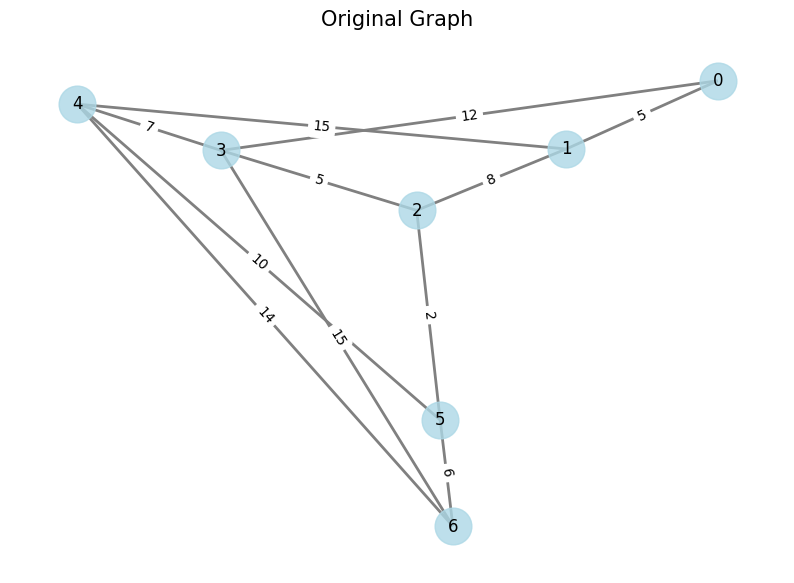



List of all edges: [(2, 5, 2), (0, 1, 5), (2, 3, 5), (5, 6, 6), (3, 4, 7), (1, 2, 8), (4, 5, 10), (0, 3, 12), (4, 6, 14), (1, 4, 15), (3, 6, 15)] 



In [38]:
# Original Graph
graph.show_info()
graph.visualize(graph.sorted_edges, master_pos, 'Original Graph')
print('\n')
print('List of all edges:', graph.sorted_edges, '\n')

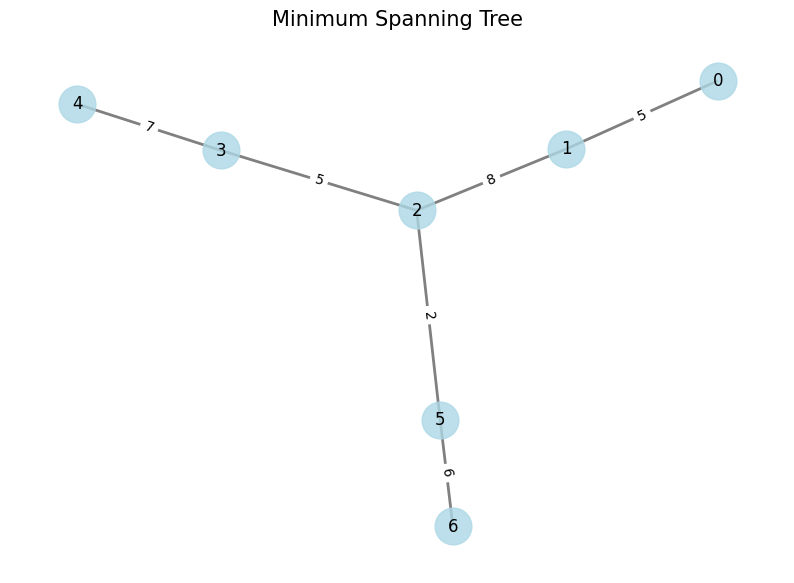



MST total weight: 33 



In [39]:
# MST
graph.visualize(MST_edges, master_pos, 'Minimum Spanning Tree')
print('\n')
print('MST total weight:', MST_sum_weight,'\n')

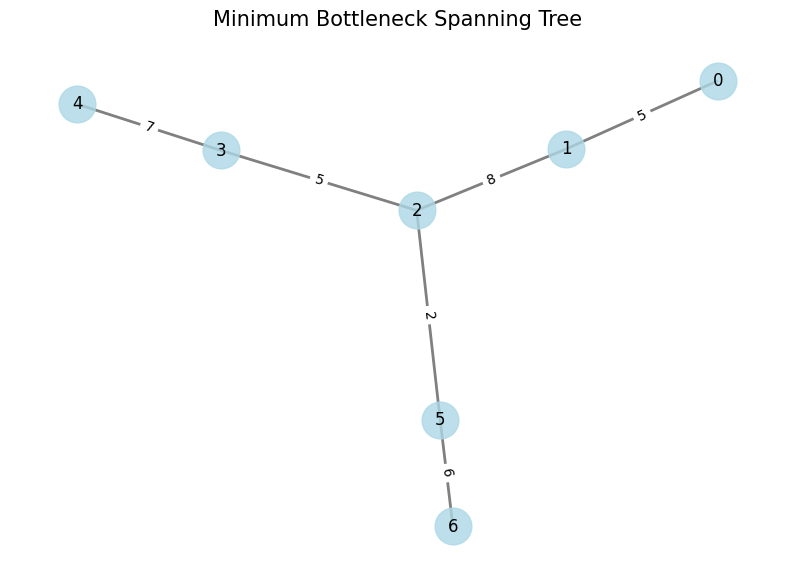




 List of all MBSTs: [[(0, 1, 5), (1, 2, 8), (2, 3, 5), (2, 5, 2), (3, 4, 7), (5, 6, 6)]]
Number of MBSTs: 1
Minimum max weight: 8 



In [40]:
# MBST
graph.visualize (MBSTs[0], master_pos, 'Minimum Bottleneck Spanning Tree')
print('\n')
print('List of all MBSTs:', MBSTs)
print('Number of MBSTs:', len(MBSTs))
print('Minimum max weight:', bottleneck, '\n')

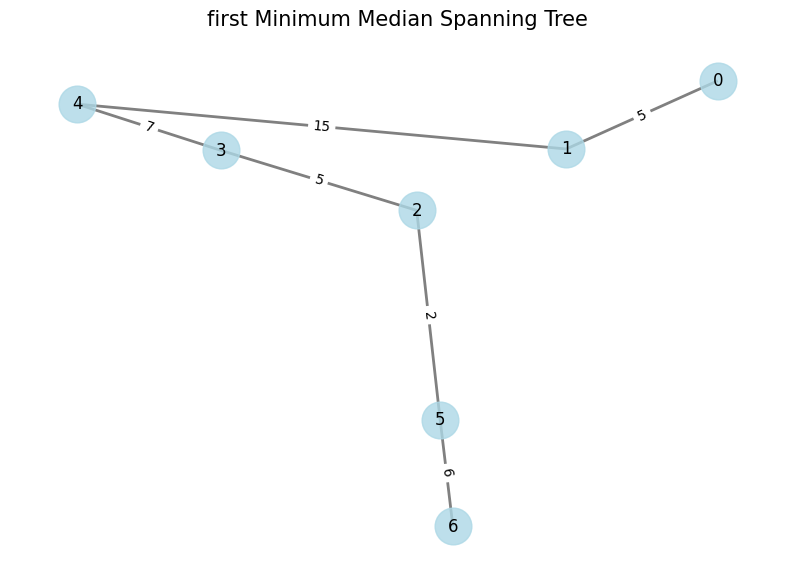

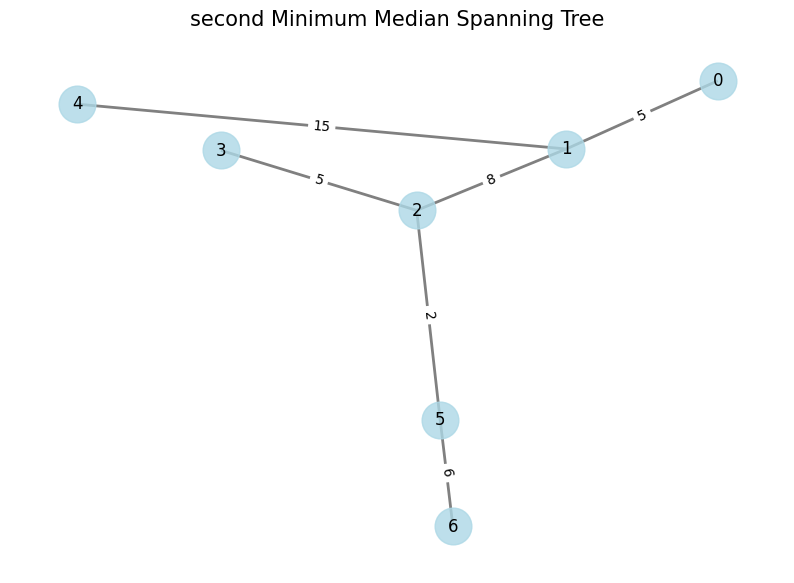



List of all MMSTs: [[(0, 1, 5), (1, 4, 15), (2, 3, 5), (2, 5, 2), (3, 4, 7), (5, 6, 6)], [(0, 1, 5), (1, 2, 8), (1, 4, 15), (2, 3, 5), (2, 5, 2), (5, 6, 6)], [(0, 1, 5), (1, 2, 8), (2, 3, 5), (2, 5, 2), (3, 4, 7), (5, 6, 6)], [(0, 1, 5), (0, 3, 12), (2, 3, 5), (2, 5, 2), (3, 4, 7), (5, 6, 6)]]
Number of MMSTs: 4
Minimum median: 5.5 





In [41]:
# MMST (first and second instance)
graph.visualize(MMSTs[0], master_pos, 'first Minimum Median Spanning Tree')
graph.visualize(MMSTs[1], master_pos, 'second Minimum Median Spanning Tree')
print('\n')
print('List of all MMSTs:', MMSTs)
print('Number of MMSTs:', len(MMSTs))
print('Minimum median:', median, '\n')

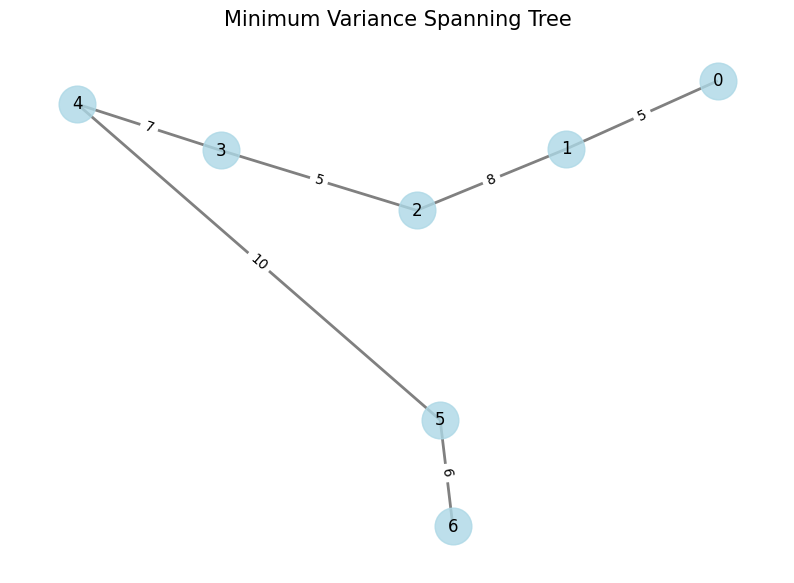



List of all MMSTs: [[(0, 1, 5), (1, 2, 8), (2, 3, 5), (3, 4, 7), (4, 5, 10), (5, 6, 6)]]
Number of MVSTs possible: 1
Minimum variance: 3.1388888888888893 



In [42]:
# MVST
graph.visualize(MVSTs[0], master_pos, 'Minimum Variance Spanning Tree')
print('\n')
print('List of all MMSTs:', MVSTs)
print('Number of MVSTs possible:', len(MVSTs))
print('Minimum variance:', var, '\n')

## Conclusion
#### **MST** minimizes total weight but not variance. **MBST** guarantees minimal bottleneck. **MMST** reduces the median weight. **MVST** reduces variance, balancing tree edge distribution.


#### Each tree emphasizes a different type of optimality.  
#### These distinctions are crucial in applications where trade-offs exist between cost, stability, and fairness in network design.

## References

1. Cormen, T. H., Leiserson, C. E., Rivest, R. L., & Stein, C. (2009). *Introduction to Algorithms* (3rd ed.). [PDF](https://archive.org/details/introduction-to-algorithms-third-edition-2009/page/n6/mode/1up?).

2. NetworkX Documentation: https://networkx.org/

3. Matplotlib Documentation: https://matplotlib.org/

4. Camerini, P. M. (1978). The Minimum Bottleneck Spanning Tree Problem. Information Processing Letters, 7(1), 1–3. [ScienceDirect](https://www.sciencedirect.com/science/article/abs/pii/0020019078900303?via%3Dihub).

4. Hamacher, H. W., & Ruhe, G. (1994). Minimum median spanning tree problem. *Kluwer Academic Publishers.* [PDF](https://kluedo.ub.rptu.de/frontdoor/deliver/index/docId/4857/file/Hamacher_On+spanning+tree+problems+with+multiple+objectives.pdf)

5. IIASA. (1987). *Minimum spanning tree research report*. [PDF](https://pure.iiasa.ac.at/id/eprint/2935/1/WP-87-117.pdf)
